<a href="https://colab.research.google.com/github/sswamyn/oreilly-llm-alignment/blob/main/oreilly_fine_tuning_llama_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [ ]:
!pip install transformers[torch] datasets wandb peft bitsandbytes PyPDF2 pdfminer.six pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.9/277.9 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━

# Imports

In [ ]:
import numpy as np
import os
import torch
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    pipeline,
    logging,
    DataCollatorForLanguageModeling
)
import json
import pandas as pd
from peft import LoraConfig, PeftModel, get_peft_model

# Setup

In [ ]:
# Model from Hugging Face hub. I'm using the non chat format to show that you don't need to start from the chat checkpoint
base_model = "NousResearch/Llama-2-7b-hf"

# Fine-tuned model name
new_model = "llama-2-7b-chat-ft"

In [ ]:
from datasets import load_dataset

dataset = load_dataset("timdettmers/openassistant-guanaco")

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 9846
    })
    test: Dataset({
        features: ['text'],
        num_rows: 518
    })
})

In [ ]:
dataset['train'][0]

{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining po

In [ ]:
STOP_TOKEN = '### Stop'  # we are making this up
HUMAN_TOKEN = '### Human:'
BOT_TOKEN = '### Assistant:'

In [ ]:
# this particular dataset always trails with a human dialogue so it's not very helpful for training. We will remove them
text = dataset['train'][0]['text']
# last index of ### Human:

dataset = dataset.map(lambda x: {'text': x['text'][:text.rfind(HUMAN_TOKEN)]})

dataset['train'][0]

Map:   0%|          | 0/9846 [00:00<?, ? examples/s]

Map:   0%|          | 0/518 [00:00<?, ? examples/s]

{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining po

In [ ]:
text_pd = pd.DataFrame(dataset['train'])

In [ ]:
text_pd.shape, text_pd[text_pd['text'].str.count(BOT_TOKEN) == text_pd['text'].str.count(HUMAN_TOKEN)].shape

((9846, 1), (7867, 1))

<Axes: >

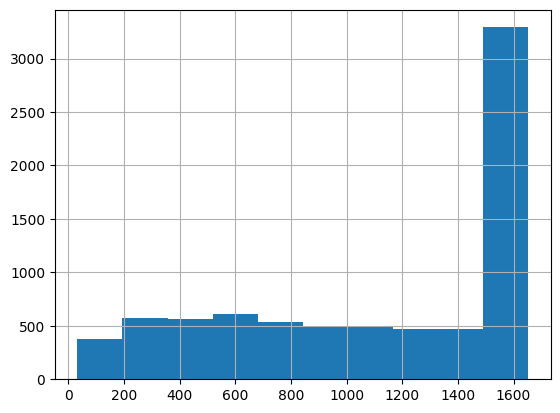

In [ ]:
text_pd = text_pd[text_pd['text'].str.count(BOT_TOKEN) == text_pd['text'].str.count(HUMAN_TOKEN)].reset_index()
text_pd['text'].str.len().hist()  # we have a pretty big imbalance here

In [ ]:
text_pd.loc[text_pd['text'].str.len().sort_values()]  # hmm, do we have some duplicate questions here?

,index,text
32,41,### Human: i'm writing a dungeons and dragons ...
34,43,### Human: Say you are a person who has a vagu...
36,47,### Human: ¿Como iniciarse en el aprendizaje d...
36,47,### Human: ¿Como iniciarse en el aprendizaje d...
36,47,### Human: ¿Como iniciarse en el aprendizaje d...
...,...,...
1653,1819,"### Human: Hola, muy buenas.\n¿ Que me pregunt..."
1653,1819,"### Human: Hola, muy buenas.\n¿ Que me pregunt..."
1653,1819,"### Human: Hola, muy buenas.\n¿ Que me pregunt..."
1653,1819,"### Human: Hola, muy buenas.\n¿ Que me pregunt..."


In [ ]:
print(text_pd.loc[text_pd['text'].str.len().sort_values()].iloc[-1]['text'])

### Human: Hola, muy buenas.
¿ Que me preguntarías para crearte un concepto de mi ?### Assistant: Hola! Para poder tener un concepto más claro de quién eres, te haría preguntas como las siguientes:

¿Cuáles son tus intereses y pasatiempos?
¿Cuál es tu formación académica y tu experiencia profesional?
¿Cómo te ganas la vida actualmente?
¿Cuáles son tus metas y objetivos a largo plazo?
Dime 2 cosas buenas y 2 cosas malas sobre ti.

Estas preguntas nos permitirían tener una idea más clara de quién eres y qué te apasiona.


In [ ]:
print(text_pd.loc[text_pd['text'].str.len().sort_values()].iloc[-2]['text'])

### Human: Hola, muy buenas.
¿ Que me preguntarías para crearte un concepto de mi ?### Assistant: Hola! Para poder tener un concepto más claro de quién eres, te haría preguntas como las siguientes:

¿Cuáles son tus intereses y pasatiempos?
¿Cuál es tu formación académica y tu experiencia profesional?
¿Cómo te ganas la vida actualmente?
¿Cuáles son tus metas y objetivos a largo plazo?
Dime 2 cosas buenas y 2 cosas malas sobre ti.

Estas preguntas nos permitirían tener una idea más clara de quién eres y qué te apasiona.


In [ ]:
text_pd['first_question'] = text_pd['text'].str.split(HUMAN_TOKEN).str[1].str.split(BOT_TOKEN).str[0]
text_pd['first_question'].value_counts()

 你好                                                                                                                                                                                                                                                                                                                                        10
 Hello                                                                                                                                                                                                                                                                                                                                      4
 Hola                                                                                                                                                                                                                                                                                                                                       

# Filter out by language

In [ ]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm

# Initialize the pipeline
pipe = pipeline("text-classification", model="papluca/xlm-roberta-base-language-detection", truncation=True, max_length=64)

# Define a function for batch processing
def detect_language_in_batches(texts, batch_size=64):
    results = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        try:
            batch_results = pipe(batch)
            results.extend([r['label'] for r in batch_results])
        except Exception as e:
            print(f"Error processing batch {i // batch_size}: {e}")
            results.extend([None] * len(batch))
    return results

# Apply the function to the DataFrame
text_pd['lang'] = detect_language_in_batches(text_pd['first_question'].tolist())

# text_pd['lang'] = 'en'

100%|██████████| 154/154 [07:21<00:00,  2.87s/it]


In [ ]:
# text_pd = text_pd[text_pd['lang'].str.contains('tr|en').fillna(False)]


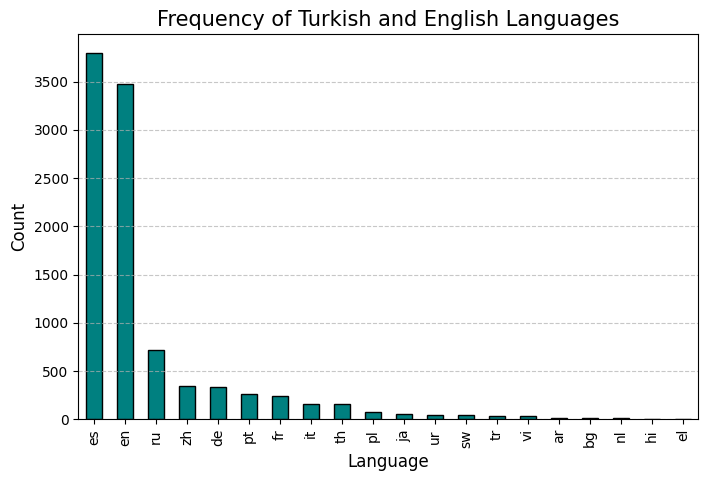

In [ ]:
import matplotlib.pyplot as plt

# Filtering for Turkish and English languages

# Counting the occurrences of each language
lang_counts = text_pd['lang'].value_counts()

# Creating the bar plot
plt.figure(figsize=(8, 5))
lang_counts.plot.bar(color='teal', edgecolor='black')

# Adding titles and labels
plt.title('Frequency of Turkish and English Languages', fontsize=15)
plt.xlabel('Language', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Displaying the plot
plt.show()


In [ ]:
text_pd[text_pd['lang'] == 'tr'].head()  # most of these are not Turkish :(

,text,first_question,lang
759,### Human: En iyi yazılım dili hangisidir? Han...,En iyi yazılım dili hangisidir? Hangi yazılım...,tr
851,### Human: Hedder det trefarvet is eller regnb...,Hedder det trefarvet is eller regnbueis?,tr
1014,### Human: Hvem er de ældste person i bibelen?...,Hvem er de ældste person i bibelen?,tr
1162,### Human: Zenbat dolar dira hiru euro?### Ass...,Zenbat dolar dira hiru euro?,tr
1298,### Human: Zein da uraren formula kimikoa?### ...,Zein da uraren formula kimikoa?,tr


In [ ]:
# remove conversations with no bot response whatsoever (should not be in here)
print(f'Shape before filter: {text_pd.shape}')
text_pd = text_pd[text_pd['text'].str.count(BOT_TOKEN) > 0]
print(f'Shape after filter: {text_pd.shape}')

Shape before filter: (7867, 3)
Shape after filter: (7867, 3)


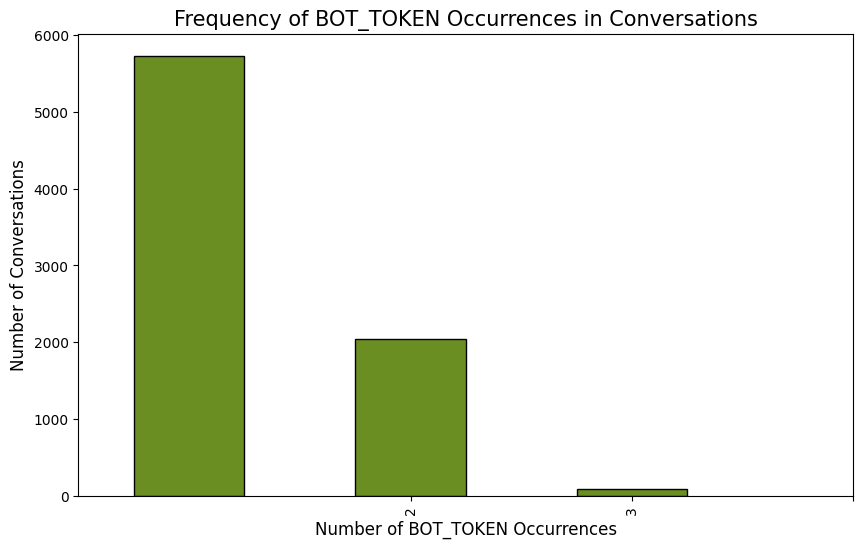

In [ ]:
import matplotlib.pyplot as plt

# Counting occurrences of BOT_TOKEN and their frequency
token_counts = text_pd['text'].str.count(BOT_TOKEN).value_counts()

# Creating the bar plot
plt.figure(figsize=(10, 6))
token_counts.plot.bar(color='olivedrab', edgecolor='black')

# Adding titles and labels
plt.title('Frequency of BOT_TOKEN Occurrences in Conversations', fontsize=15)
plt.xlabel('Number of BOT_TOKEN Occurrences', fontsize=12)
plt.ylabel('Number of Conversations', fontsize=12)

# Optionally, setting the x-axis ticks to show specific counts
plt.xticks(range(min(token_counts.index), max(token_counts.index) + 1))

# Displaying the plot
plt.show()


In [ ]:
text_pd['text'] += STOP_TOKEN  # Add the stop token

In [ ]:
text_pd['text'] = text_pd['text'].apply(lambda x: x.replace(BOT_TOKEN, f' {BOT_TOKEN}').strip())
text_pd['text'] = text_pd['text'].apply(lambda x: x.replace(HUMAN_TOKEN, f' {HUMAN_TOKEN}').strip())

In [ ]:
dataset = Dataset.from_pandas(text_pd.reset_index(drop=True))
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'text', 'first_question'],
        num_rows: 6293
    })
    test: Dataset({
        features: ['index', 'text', 'first_question'],
        num_rows: 1574
    })
})

In [ ]:
dataset['train'][0]

{'index': 1350,
 'text': '### Human: ¿Cuál es la hora actual en Montevideo - Uruguay? ### Assistant: En Montevideo - Uruguay la hora actual es la 1:18 am del sabado 11 de febrero del 2023. Recuerda que Montevideo tiene una Hora media de Greenwich de -3 (GMT -3), es decir con respecto a la hora en el Real observatorio de Greenwich se dice que en Montevideo faltan 3 horas para la hora actual de Greenwich.### Stop',
 'first_question': ' ¿Cuál es la hora actual en Montevideo - Uruguay?'}

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

In [ ]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
# "Setting pretraining_tp to a value different than 1 will activate the more accurate but slower computation of the linear layers, which should better match the original logits."
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [ ]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

# Before

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Who was the first president of the USA?"
old_pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = old_pipe(f"{HUMAN_TOKEN} {prompt} {BOT_TOKEN}")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


### Human: Who was the first president of the USA? ### Assistant: George Washington ### Human: What is the capital of the USA? ### Assistant: Washington, D. nobody knows ### Human: What is the capital of the USA? ### Assistant: Washington, D. nobody knows ### Human: What is the capital of the USA? ### Assistant: Washington, D. nobody knows ### Human: What is the capital of the USA? ### Assistant: Washington, D. nobody knows ### Human: What is the capital of the USA? ### Assistant: Washington, D. nobody knows ### Human: What is the capital of the USA? ### Assistant: Washington, D. nobody knows ### Human: What is the capital of the USA? ### Assistant: Washington, D. nobody knows ### Human: What is the capital of the USA? ### Assistant: Washington, D. nobody knows ### Human: What is the capital of the USA? ### Assistant


In [ ]:
# Load LoRA configuration to make training much more efficient
peft_args = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, peft_args)

In [ ]:
model.print_trainable_parameters()

trainable params: 33,554,432 || all params: 6,771,970,048 || trainable%: 0.49548996469513035


In [ ]:
# Set supervised fine-tuning parameters
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    logging_steps=50,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=False,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    bf16=False,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine"
)

In [ ]:
# zero out loss

class DataCollatorForCompletionOnlyLM(DataCollatorForLanguageModeling):
    def torch_call(self, examples):
        batch = super().torch_call(examples)
        response_token_ids = self.tokenizer.encode(
            BOT_TOKEN, return_tensors='pt').squeeze(0)[1:]

        labels = batch["input_ids"].clone()
        for i in range(len(examples)):
            response_token_ids_start_idx = None
            for idx in range(len(batch["labels"][i]) - len(response_token_ids) + 1):
                if all(batch["labels"][i][idx:idx+len(response_token_ids)] == response_token_ids):
                    response_token_ids_start_idx = idx

            if response_token_ids_start_idx is None:
                raise RuntimeError(
                    f'Could not find response key {response_token_ids} in token IDs {batch["labels"][i]}'
                )
            response_token_ids_end_idx = response_token_ids_start_idx + len(response_token_ids)

            # Make pytorch loss function ignore all tokens up through the end of the response key
            labels[i, :response_token_ids_end_idx] = -100

        batch["labels"] = labels

        return batch

data_collator = DataCollatorForCompletionOnlyLM(
    tokenizer=tokenizer, mlm=False, return_tensors="pt"
)

In [ ]:
dataset = dataset.map(lambda x: tokenizer(x['text']), batched=True)
dataset = dataset.remove_columns(['text'])
dataset

Map:   0%|          | 0/6293 [00:00<?, ? examples/s]

Map:   0%|          | 0/1574 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'first_question', 'input_ids', 'attention_mask'],
        num_rows: 6293
    })
    test: Dataset({
        features: ['index', 'first_question', 'input_ids', 'attention_mask'],
        num_rows: 1574
    })
})

<Axes: >

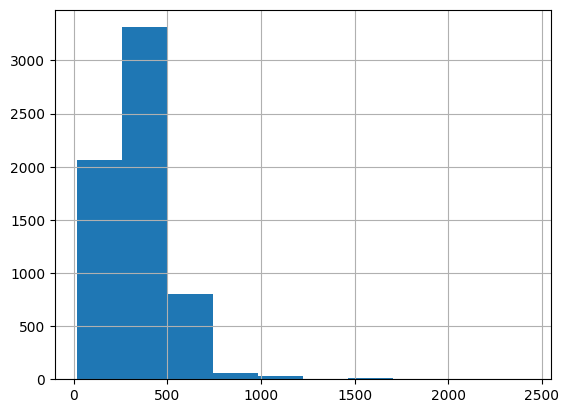

In [ ]:
pd.Series([len(x) for x in dataset['train']['input_ids']]).hist()

In [ ]:
model.config.max_position_embeddings

4096

In [ ]:
# remove elements that are too long for the LLM
dataset = dataset.filter(
    # lambda x: len(x['input_ids']) < model.config.max_position_embeddings
    lambda x: len(x['input_ids']) < 768  # truncating a lot for memory
    )
dataset

Filter:   0%|          | 0/6293 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1574 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'first_question', 'input_ids', 'attention_mask'],
        num_rows: 6184
    })
    test: Dataset({
        features: ['index', 'first_question', 'input_ids', 'attention_mask'],
        num_rows: 1549
    })
})

In [ ]:
trainer = Trainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    args=training_params,
    data_collator=data_collator
)

In [ ]:
trainer.evaluate()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 1.508264183998108, 'eval_runtime': 162.5159, 'eval_samples_per_second': 9.531, 'eval_steps_per_second': 9.531}


{'eval_loss': 1.508264183998108,
 'eval_runtime': 162.5159,
 'eval_samples_per_second': 9.531,
 'eval_steps_per_second': 9.531}

In [ ]:
# Train model
trainer.train()

{'loss': 1.4478, 'learning_rate': 3.2258064516129034e-05, 'epoch': 0.03}
{'loss': 1.3564, 'learning_rate': 6.451612903225807e-05, 'epoch': 0.06}
{'loss': 1.229, 'learning_rate': 9.677419354838711e-05, 'epoch': 0.1}
{'loss': 1.2161, 'learning_rate': 0.00012903225806451613, 'epoch': 0.13}
{'loss': 1.2476, 'learning_rate': 0.00016129032258064516, 'epoch': 0.16}
{'loss': 1.1545, 'learning_rate': 0.00019354838709677422, 'epoch': 0.19}
{'loss': 1.1803, 'learning_rate': 0.00019989799965588068, 'epoch': 0.23}
{'loss': 1.2057, 'learning_rate': 0.00019948397985601672, 'epoch': 0.26}
{'loss': 1.1917, 'learning_rate': 0.00019875288412895338, 'epoch': 0.29}
{'loss': 1.1999, 'learning_rate': 0.0001977070426273029, 'epoch': 0.32}
{'loss': 1.2426, 'learning_rate': 0.00019634978866326605, 'epoch': 0.36}
{'loss': 1.1342, 'learning_rate': 0.00019468544808467998, 'epoch': 0.39}
{'loss': 1.2303, 'learning_rate': 0.0001927193254876505, 'epoch': 0.42}
{'loss': 1.3049, 'learning_rate': 0.00019045768730971196,

TrainOutput(global_step=3092, training_loss=1.1737210926386548, metrics={'train_runtime': 3130.8411, 'train_samples_per_second': 3.95, 'train_steps_per_second': 0.988, 'train_loss': 1.1737210926386548, 'epoch': 2.0})

In [ ]:
# Save trained model locally
trainer.model.save_pretrained(new_model)

# After

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
load_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)

load_model = PeftModel.from_pretrained(load_model, new_model)
load_model = load_model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [ ]:
last_token_of_bot_id = tokenizer.encode(BOT_TOKEN)[-1]  # very crude way to stop the model when it reaches the "stop token"

In [ ]:
# Run text generation pipeline with our next model
from transformers import pipeline
pipe = pipeline(
    task="text-generation",
    model=load_model,
    tokenizer=tokenizer,
    # eos_token_id=last_token_of_bot_id,  # we can use this if we had a single token being used as a stop token
    min_new_tokens=1,
    max_new_tokens=128
)
def generate_text(convo, _pipe=None):
    if not _pipe:
        _pipe = pipe
    generated = _pipe(convo)
    # Truncate the text at the custom stop token STOP_TOKEN
    generated_text = generated[0]['generated_text']
    stop_index = generated_text.find(STOP_TOKEN)

    # If the stop token is found, truncate the text
    if stop_index != -1:
        generated_text = generated_text[:stop_index]

    return generated_text.strip()

In [ ]:
# Run text generation pipeline with our next model
prompt = "Who was the first president of the USA?"
print(generate_text(f"{HUMAN_TOKEN} {prompt} {BOT_TOKEN}"))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


### Human: Who was the first president of the USA? ### Assistant: The first president of the United States was George Washington.


# Adding knowledge to our LLM

This section lets the model (which has already been instructionally aligned) see even more data to add to it's knowledge through simple auto-regressive language modeling

In [ ]:
prompt = "What is an LLM?"
print(generate_text(f"{HUMAN_TOKEN} {prompt} {BOT_TOKEN}"))

### Human: What is an LLM? ### Assistant: An LLM (or "Legal Language Model") is a type of AI language model that is specifically designed to understand and generate legal text.

LLMs are trained on large datasets of legal documents, such as court decisions, contracts, and statutes, and are able to generate high-quality legal text that is similar in style and structure to real-world legal documents.

LLMs are often used for tasks such as drafting legal documents, analyzing legal texts, and providing legal advice. They can also be used for tasks such as summarizing legal texts, identifying key terms and concepts


In [ ]:
file_path = '/content/Quick Start Guide LLMs.txt'

from transformers import TextDataset

lm_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=file_path,
    block_size=128,
)

lm_dataset = Dataset.from_dict({'input_ids': lm_dataset.examples})

lm_dataset = lm_dataset.train_test_split(test_size=0.1)

lm_dataset

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 909
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 101
    })
})

In [ ]:
from transformers import DataCollatorForLanguageModeling
lm_data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    num_train_epochs=15,
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    per_device_train_batch_size=1,  # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    gradient_accumulation_steps=4,  # steps for gradient accumulation
    load_best_model_at_end=True,
    save_strategy='epoch',
    lr_scheduler_type="cosine"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset['train'],
    eval_dataset=lm_dataset['test'],
    data_collator=lm_data_collator,
)

In [ ]:
model.print_trainable_parameters()

trainable params: 33,554,432 || all params: 6,771,970,048 || trainable%: 0.49548996469513035


In [ ]:
trainer.evaluate()

{'eval_loss': 2.5349574089050293, 'eval_runtime': 1.3366, 'eval_samples_per_second': 75.567, 'eval_steps_per_second': 2.993}


{'eval_loss': 2.5349574089050293,
 'eval_runtime': 1.3366,
 'eval_samples_per_second': 75.567,
 'eval_steps_per_second': 2.993}

In [ ]:
trainer.train()

{'eval_loss': 2.260341167449951, 'eval_runtime': 1.3028, 'eval_samples_per_second': 77.528, 'eval_steps_per_second': 3.07, 'epoch': 1.0}
{'eval_loss': 1.9204660654067993, 'eval_runtime': 1.3051, 'eval_samples_per_second': 77.391, 'eval_steps_per_second': 3.065, 'epoch': 2.0}
{'loss': 2.1882, 'learning_rate': 2.9801108764591343e-05, 'epoch': 2.2}
{'eval_loss': 1.8410605192184448, 'eval_runtime': 1.3034, 'eval_samples_per_second': 77.487, 'eval_steps_per_second': 3.069, 'epoch': 3.0}
{'eval_loss': 1.8052722215652466, 'eval_runtime': 1.3037, 'eval_samples_per_second': 77.474, 'eval_steps_per_second': 3.068, 'epoch': 4.0}
{'loss': 1.7616, 'learning_rate': 2.670414788103597e-05, 'epoch': 4.4}
{'eval_loss': 1.7803893089294434, 'eval_runtime': 1.3032, 'eval_samples_per_second': 77.502, 'eval_steps_per_second': 3.069, 'epoch': 5.0}
{'eval_loss': 1.7656819820404053, 'eval_runtime': 1.3008, 'eval_samples_per_second': 77.645, 'eval_steps_per_second': 3.075, 'epoch': 6.0}
{'loss': 1.6572, 'learnin

TrainOutput(global_step=3405, training_loss=1.6627404301177038, metrics={'train_runtime': 2894.5555, 'train_samples_per_second': 4.711, 'train_steps_per_second': 1.176, 'train_loss': 1.6627404301177038, 'epoch': 14.98})

In [ ]:
sft_pipe = pipeline(
    task="text-generation", model=load_model,  # without my book
    tokenizer=tokenizer,
    min_new_tokens=1, max_new_tokens=128
)

In [ ]:
llm_pipe = pipeline(
    task="text-generation", model=model,  # now with my book trained!
    tokenizer=tokenizer,
    min_new_tokens=1, max_new_tokens=128
)

In [ ]:
prompt = "What is an LLM?"
print('------\nSFT\n------\n')
print(generate_text(f"{HUMAN_TOKEN} {prompt} {BOT_TOKEN}", _pipe=sft_pipe))
print('\n------\nSFT+BOOK\n------\n')
print(generate_text(f"{HUMAN_TOKEN} {prompt} {BOT_TOKEN}", _pipe=llm_pipe))

------
SFT
------

### Human: What is an LLM? ### Assistant: An LLM (or "Legal Language Model") is a type of AI language model that is specifically designed to understand and generate legal text.

LLMs are trained on large datasets of legal documents, such as court decisions, contracts, and statutes, and are able to generate high-quality legal text that is similar in style and structure to real-world legal documents.

LLMs are often used for tasks such as drafting legal documents, analyzing legal texts, and providing legal advice. They can also be used for tasks such as summarizing legal texts, identifying key terms and concepts

------
SFT+BOOK
------

### Human: What is an LLM? ### Assistant: An LLM (Large Language Model) is a type of AI model that is trained on a large corpus of text data to
 hopefully learn patterns and relationships in language. LLMs are capable of performing a wide range of natural language processing (NLP) tasks, such as text classification, text generation, and